In [1]:
import sys, os
import ujson as json
from pathlib import Path 
HOME = "/rds/general/user/dl2119/home/ICLR_Interp" # Path(os.environ["PATH_INTP_FOLDER"])
os.environ["PATH_INTP_FOLDER"] = HOME
HOME = Path(HOME)
sys.path.append(str(HOME))
sys.path.append(str(HOME / "DataGeneration"))
sys.path.append(str(HOME / "ModelGeneration"))

from save_load_data import load_fast
from save_load_model import save_nn
from nn_train import train

import torch
import torchvision
import torch.optim as optim
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt 

from Functions import Schwefel
import numpy as np

%load_ext autoreload
%autoreload 2

TODO : 
Check the models we have for anomalities and things we can get rid of. -- Seems like everything is ok. just how it is. Maybe run some stuff longer. 

Copy both models and data into a new "old" folder

For fast loading, add last loss to file name
Run all models again on the new data. Adapt the array index for large datasets and so that i split some of the models for higher Ns. Maybe do this manually. 

Code up some test functions while this is running. See how long it takes to get different RBFs and stuff. Compute losss on testsets and stuff. 

Need to still do visualizations... 





In [2]:
class SimpleNet(Module):
    def __init__(self, inp_dim, out_dim, width, num_layers, dropout_p=0, activation=None):
        super(SimpleNet, self).__init__()

        self.dropout_p = dropout_p
        
        if activation is None or activation == "relu":
            self.activation = F.relu
        if activation == "sigmoid":
            self.activation = F.hardsigmoid
        if activation == "tanh":
            self.activation = F.hardtanh

        self.fc_input = nn.Linear(inp_dim, width)
        self.layers = nn.ModuleList([nn.Linear(width, width) for _ in range(num_layers - 1)])
        self.fc_final = nn.Linear(width, out_dim)

    def forward(self, x):
        x = self.activation(self.fc_input(x))
        for i in range(len(self.layers)):
            x = self.activation(self.layers[i](x))
        x = self.fc_final(x)
        return x

In [3]:
def load_model(path):
    path = str(path)
    model_config = path.split("/")[-2]
    depth = model_config.split("_")[2]
    width = model_config.split("_")[4]
    dim = (path.split("/")[-5]).split("_")[1]
    
    depth = int(depth)
    width = int(width)
    dim = int(dim)
    
    model = SimpleNet(dim, 1, width, depth)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model 

In [4]:
import pandas as pd

In [93]:
data_df = pd.DataFrame(res_data)

In [99]:
data_dir_path = HOME / "Dataset"

res_data = []


for func_name in os.listdir(data_dir_path):
    print(func_name)
    for dim in os.listdir(data_dir_path / func_name):
        for N in os.listdir(data_dir_path / func_name / dim):
            for data_gen_method in os.listdir(data_dir_path / func_name / dim / N):    
                curr_dir = {"func_name": func_name, "dim": dim.split("_")[1], 
                            "N": N.split("_")[1], "data_type": data_gen_method}
    
                res_data.append(curr_dir)

Schwefel
Michi
Ackley
Rosenbrock


In [17]:
model_dir_path = HOME / "ModelsOld"

res_models = []

criterion = torch.nn.MSELoss(reduction="mean")


for func_name in os.listdir(model_dir_path):
    print(func_name)
    for dim in os.listdir(model_dir_path / func_name):
        print("dim", dim)
        for N in os.listdir(model_dir_path / func_name / dim):
            for data_gen_method in os.listdir(model_dir_path / func_name / dim / N):
                for nn_type in os.listdir(model_dir_path / func_name / dim / N / data_gen_method):
                    
                    curr_dir = {"func_name": func_name, "dim": dim.split("_")[1], 
                                "N": N.split("_")[1], "data_type": data_gen_method, "nn_type": nn_type} #, "loss": loss_hist[-1]}
                    res_models.append(curr_dir)
    

Schwefel
dim dim_8
dim dim_6
dim dim_1
dim dim_4
dim dim_2
dim dim_10
dim dim_3
Michi
dim dim_8
dim dim_6
dim dim_1
dim dim_4
dim dim_2
dim dim_10
dim dim_3
Ackley
dim dim_8
dim dim_6
dim dim_1
dim dim_4
dim dim_2
dim dim_10
dim dim_3
Rosenbrock
dim dim_8
dim dim_6
dim dim_1
dim dim_4
dim dim_2
dim dim_10
dim dim_3


In [13]:


funcs = ["Schwefel", "Ackley", "Michi", "Rosenbrock"]
dims = [1, 2, 3, 4, 6, 8, 10]
Ns = [1e2, 1e3, 1e4, 1e5, 1e6]
data_gen_methods = ["UniformRandom", "UniformGrid", "HessSampling"]

def gen_nn_tags():
    batch_sizes = [16, 64, 256]

    depth_widths = [{'depth': 4, 'width': 4},
                    {'depth': 4, 'width': 32},
                    {'depth': 4, 'width': 128},
                    {'depth': 8, 'width': 32},
                    {'depth': 8, 'width': 128},
                    {'depth': 16, 'width': 32},
                    {'depth': 16, 'width': 128}]


    optimizers = {"Adam": {"lr": [0.001, 0.0001, 1e-5], "momentum": [0.]}, "SGD": {"lr": [1e-2, 1e-3, 1e-4, 1e-5], "momentum": [0., 0.9]}}

    weight_decays = [0, 1e-3, 1]
    res = []
    for depth_width in depth_widths:
        depth = depth_width["depth"]
        width = depth_width["width"]
        for optimizer in optimizers:
            for batch_size in batch_sizes:
                for lr in optimizers[optimizer]["lr"]:
                    for momentum in optimizers[optimizer]["momentum"]:
                        for weight_decay in weight_decays:
                            
                            if optimizer == "SGD":
                                optimizer_str = optimizer + "_{}".format(momentum)
                            else:
                                optimizer_str = optimizer

                            dir_name = "nn_depth_{}_width_{}_opt_{}_lr_{}_bs_{}_l2p_{}".format(depth, width, optimizer_str, lr, batch_size, weight_decay)
                            res.append(dir_name)
                            
    return res
desired_models = []
nn_tags = gen_nn_tags()
for func_name in funcs:
        for dim in dims:
            for N in Ns:
                for data_gen_method in data_gen_methods:
                    curr_dirs = [{"func_name": func_name, "dim": dim,
                                "N": N, "data_type": data_gen_method, "nn_type": nn_type} for nn_type in nn_tags] #, "loss": loss_hist[-1]}
                    desired_models += curr_dirs

In [14]:
len(desired_models)

291060

In [18]:
len(res_models)

219264

In [41]:
ls = []
bad_ms = []
for r in res_models:
    ls.append(r['loss'])
    if ls[-1] > 5:
        bad_ms.append(r)

In [44]:

    batch_sizes = [16, 64, 256]

    depth_widths = [{'depth': 4, 'width': 4},
                    {'depth': 4, 'width': 32},
                    {'depth': 4, 'width': 128},
                    {'depth': 8, 'width': 32},
                    {'depth': 8, 'width': 128},
                    {'depth': 16, 'width': 32},
                    {'depth': 16, 'width': 128}]


    optimizers = {"Adam": {"lr": [0.001, 0.0001, 1e-5], "momentum": [0.]}, "SGD": {"lr": [1e-2, 1e-3, 1e-4, 1e-5], "momentum": [0., 0.9]}}

    weight_decays = [0, 1e-3, 1]

{'func_name': 'Schwefel',
 'dim': '8',
 'N': '100',
 'data_type': 'UniformGrid',
 'nn_type': 'nn_depth_16_width_128_opt_SGD_0.0_lr_1e-05_bs_16_l2p_0.001',
 'loss': 5.559410095214844}

In [103]:
3 * 7 * (3 + 8) # * 3

231

(array([2.9724e+04, 2.0589e+04, 2.4302e+04, 2.0719e+04, 1.7447e+04,
        1.2922e+04, 1.4701e+04, 6.7280e+03, 6.1770e+03, 7.0040e+03,
        5.4450e+03, 4.4920e+03, 4.7080e+03, 5.1960e+03, 5.8250e+03,
        4.2580e+03, 3.9560e+03, 4.7940e+03, 4.1810e+03, 2.7640e+03,
        2.4080e+03, 1.9830e+03, 1.1300e+03, 8.0700e+02, 4.6600e+02,
        1.1600e+02, 5.0000e+01, 2.4000e+01, 1.3000e+01, 4.0000e+00]),
 array([1.82768199e-05, 8.27237186e-01, 1.65445609e+00, 2.48167500e+00,
        3.30889391e+00, 4.13611282e+00, 4.96333173e+00, 5.79055064e+00,
        6.61776955e+00, 7.44498846e+00, 8.27220736e+00, 9.09942627e+00,
        9.92664518e+00, 1.07538641e+01, 1.15810830e+01, 1.24083019e+01,
        1.32355208e+01, 1.40627397e+01, 1.48899586e+01, 1.57171775e+01,
        1.65443965e+01, 1.73716154e+01, 1.81988343e+01, 1.90260532e+01,
        1.98532721e+01, 2.06804910e+01, 2.15077099e+01, 2.23349288e+01,
        2.31621477e+01, 2.39893666e+01, 2.48165855e+01]),
 <BarContainer object of 30 

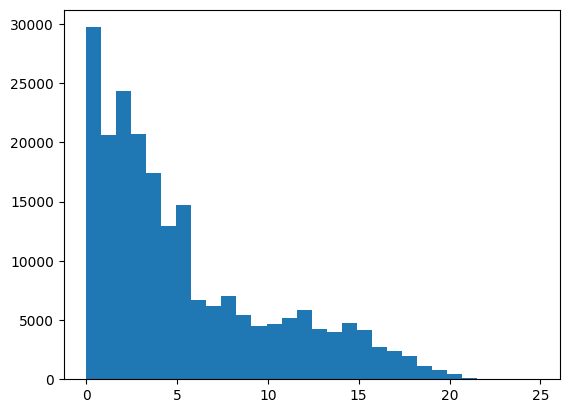

In [42]:
plt.hist(ls, bins=30)

In [15]:
from collections import defaultdict


In [22]:

def make_tree(d_arr):
    res = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: [])))
    for r in d_arr:
        res[r["func_name"]][r["dim"]][r["N"]].append(r["data_type"])
    return res 

t = make_tree(res_data)

In [24]:
for f in t:
    for dim in t[f]:
        if len(t[f][dim]) != 5:
            print("f {} dim {}".format(f, dim))
            print(t[f][dim])
            print()
        for N in t[f][dim]:
            if len(t[f][dim][N]) != 3:
                print("f {} dim {} N {}".format(f, dim, N))
                print(t[f][dim][N])
                print()

f Michi dim 8
defaultdict(<function make_tree.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda> at 0x145c1b3d91b0>, {'10000': ['UniformGrid', 'UniformRandom', 'HessSampling'], '1000': ['UniformGrid', 'UniformRandom', 'HessSampling'], '100': ['UniformGrid', 'UniformRandom', 'HessSampling'], '100000': ['UniformGrid', 'UniformRandom', 'HessSampling']})

f Michi dim 6
defaultdict(<function make_tree.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda> at 0x145c1b3d9240>, {'10000': ['UniformGrid', 'UniformRandom', 'HessSampling'], '1000': ['UniformGrid', 'UniformRandom', 'HessSampling'], '100': ['UniformGrid', 'UniformRandom', 'HessSampling'], '100000': ['UniformRandom']})

f Michi dim 6 N 100000
['UniformRandom']

f Michi dim 1
defaultdict(<function make_tree.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda> at 0x145c1b3d92d0>, {'10000': ['UniformGrid', 'UniformRandom', 'HessSampling'], '1000': ['UniformGrid', 'UniformRandom', 'HessSampling'], '100': ['UniformGrid', 'UniformRandom

# schwefel stuff

In [ ]:
def normalize(X_data, y_data):
    x_max, x_min = np.max(X_data), np.min(X_data)
    y_max, y_min = np.max(y_data), np.min(y_data)

    X_data = (X_data - (x_max + x_min)/2.) * 5. / ((x_max - x_min)/2.)
    y_data = (y_data - (y_max + y_min)/2.) * 5. / ((y_max - y_min)/2.)

    return X_data, y_data

In [63]:
func_name = "Schwefel"
dim = 8
N = 100 # int(1e6)



# net = load_model(model_dir_path / func_name / dim / N / data_gen_method / nn_type / "model.pt")



num_steps = 1e4

X_data, y_data = load_fast("Schwefel", dim, N, "UniformGrid")
X_data, y_data = normalize(X_data, y_data)


inp_dim=dim
eps = 5e-3
width = 128
num_layers = 4
optimizer_name = "SGD"
lr = 1e-2
weight_decay = 0.001
batch_size = 16
num_epochs = int(1. * num_steps / (N / batch_size))
num_epochs = max(num_epochs, 5) # want to see every data point at least 5-times
num_epochs = min(num_epochs, 200) # no more than 200 epochs

print(num_epochs)

net, loss_hist = train(inp_dim, None, X_data, y_data, num_epochs, eps, width, num_layers, optimizer_name, lr, batch_size, weight_decay, momentum=0, verbose=True)

# save_nn(net, loss_hist, "Schwefel", dim, N, "HessSampling", num_layers, width, "SGD", lr, batch_size, weight_decay, momentum=0)

  5%|▌         | 10/200 [00:00<00:01, 95.26it/s]

200


 48%|████▊     | 97/200 [00:01<00:01, 85.51it/s]


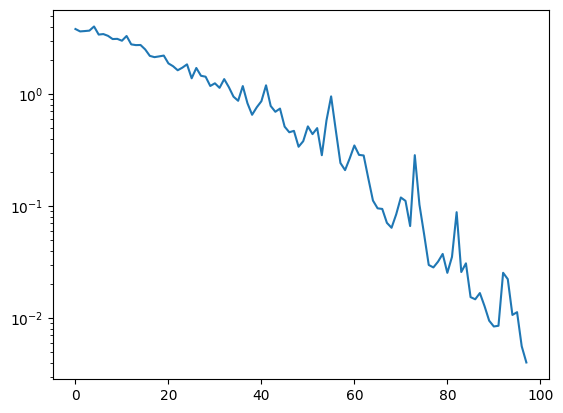

In [64]:

plt.plot([float(l) for l in loss_hist])
plt.yscale("log")

In [151]:
from Functions import Schwefel
import numpy as np

                N_int = int(N.split("_")[1])
                dim_int = int(dim.split("_")[1])
                X_data, y_data = load_fast(func_name, dim_int, N_int, data_gen_method)
                X_data = Tensor(X_data)
                y_data = Tensor(y_data).unsqueeze(1)
                
                X_data = X_data.type(torch.float32)
                y_data = y_data.type(torch.float32)

In [ ]:
X_test = np.random.uniform(low=-5, high=5, size=(1000, dim))
y_test = F.f(X_test) / 

nn_out = net(Tensor(X_test.reshape(-1, 1)))

np.linalg.norm(y_test - nn_out.detach().numpy())

In [129]:
X_test = np.random.uniform(low=-5, high=5, size=(1000, dim))
y_test = (F.f(X_test*100) - 400)/100

nn_out = net(Tensor(X_test.reshape(-1, 1)))

np.linalg.norm(y_test - nn_out.detach().numpy())

2699.346

In [114]:
Xs = Xs / 50
net_out = net(Tensor(Xs.reshape(-1, 1)))

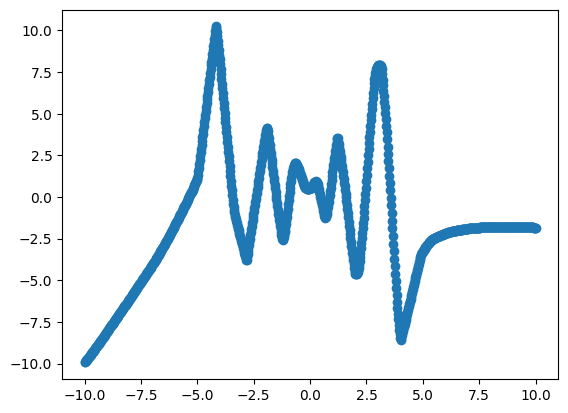

In [115]:
plt.scatter(Xs, [float(o) for o in net_out])

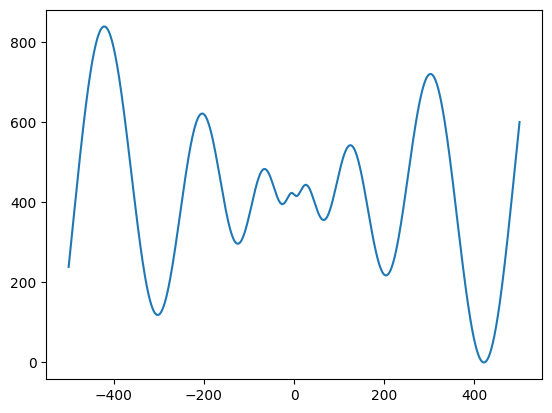

In [113]:
F = Schwefel()

Xs = np.linspace(F.bounds[0][0], F.bounds[0][1], 1000)
ys = F.f(Xs.reshape(-1, 1))
plt.plot(Xs, ys)

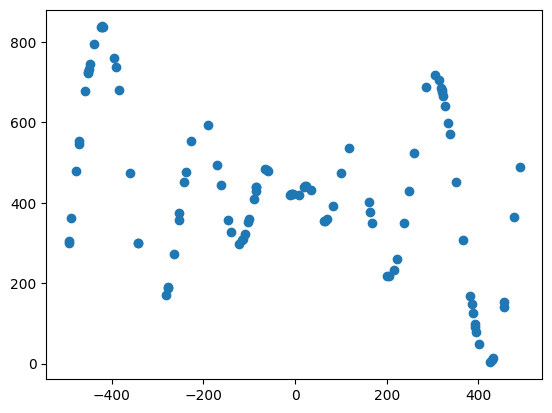

In [40]:
plt.scatter(X_data, y_data)